In [1]:
# importing dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
plt.style.use('seaborn')


# perform train-test-split - original csv file is imported again to start with a clean df
# import modules

# reading in data as df
df = pd.read_csv('Breast_Cancer.csv', delimiter=',')

# correcting typos
df = df.rename(columns={'T Stage ':'T Stage'})
df = df.rename(columns={'Reginol Node Positive': 'Regional Node Positive'})

# remapping target column
df.loc[:,'Status_encoded'] = df.loc[:,'Status'].map({'Alive':0, 'Dead':1})

# new features 
# ['Node_Examined_Pos_Rate']: Positive Nodes per Examined Nodes
df.loc[:,'Node_Exam_Pos_Rate'] = df.loc[:,'Regional Node Positive']/df.loc[:,'Regional Node Examined']
#['Progesteron_Estrogen_Status']: Positive status if status of both receptors is positive
mask = (df['Estrogen Status'] == 'Positive') | (df['Progesterone Status'] == 'Positive')
conditions = [mask, ~mask]
values = ['Positive', 'Negative']
df['Estrogen_Progesteron_Status'] = np.select(conditions, values)


# changing dtypes of columns as needed
dtypes_columns = {'Age' : 'int64',
'Race' : 'category',
'Marital Status' : 'category',
'T Stage' : 'category', 
'N Stage' : 'category',
'6th Stage' : 'category',
'differentiate' : 'category',
'Grade' : 'category',
'A Stage' : 'category', 
'Tumor Size' : 'int64',
'Estrogen Status' : 'category',
'Progesterone Status' : 'category',
'Regional Node Examined' : 'int64',
'Regional Node Positive' : 'int64',
'Survival Months' : 'int64',
'Status' : 'category',
'Status_encoded' : 'int64',
'Node_Exam_Pos_Rate': 'float64',
'Estrogen_Progesteron_Status': 'category'}
df = df.astype(dtypes_columns)

# drop 'Grade' columns because the information is the same as in the 'differentiate' column 
df.drop('Grade', axis=1, inplace=True)

# creating target and features 
target = df.loc[:,'Status_encoded']
features = df.drop('Status', axis=1)
features = features.drop('Status_encoded', axis=1)

# train and test split
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            random_state=42,
                                                                            test_size=0.1)

C:\Users\flori\AppData\Local\Temp\ipykernel_23920\4262179337.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# save features_test and target_test as 'features_test.csv' and 'target_test.csv' respectively
features_test.to_csv('features_test.csv', index=False)
target_test.to_csv('target_test.csv', index=False)

In [3]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(3621, 16)

(403, 16)

(3621,)

(403,)

In [4]:
# creating lists of categorical, ordinal and numerical columns
cat_cols = ['Race', 'Marital Status', 'Estrogen Status', 'Progesterone Status']
ord_cols = ['T Stage', 'N Stage', '6th Stage', 'differentiate', 'A Stage']
num_cols = [col for col in features_train.select_dtypes(include=["int64","float64"])]

# adding new features
cat_cols.append('Estrogen_Progesteron_Status')

# Baseline Model

In [5]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier # pipeline builder can handle 

#tree_clf = DecisionTreeClassifier(random_state=42)
search_space = {'estimator__max_depth': range(2, 16, 2),
                'estimator__class_weight': [None, 'balanced']}
samplers = [('oversampling', RandomOverSampler(random_state=42)),
            ('undersampling', RandomUnderSampler(random_state=42)),
            ('class_weights', 'passthrough'),
            ('smote', SMOTE(random_state=42))
           ]
sampling_results = []

# go through every sampler
for name, sampler in samplers:
    # sampling
    imb_pipe = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                            ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                            ('ord_transformer', OrdinalEncoder(), ord_cols)
                        ], remainder='passthrough')),
                        ('sampler', sampler),
                        ('estimator', DecisionTreeClassifier(random_state=42))
                        ])
    
    # gridsearch and CV
    grid_tree = GridSearchCV(estimator=imb_pipe, 
                        param_grid=search_space,
                        n_jobs=-1,
                        cv=5,
                        scoring='f1')
    
    grid_tree.fit(features_train, target_train)

    target_pred_tree = grid_tree.predict(features_test)

    score = {'name': "DecisionTreeClassifier with " + name.upper(),
        'accuracy': accuracy_score(target_test, target_pred_tree) * 100,
        'precision': precision_score(target_test, target_pred_tree) * 100,
        'recall': recall_score(target_test, target_pred_tree) * 100,
        'f1': f1_score(target_test, target_pred_tree) * 100,
        'best model': grid_tree.best_estimator_.named_steps['estimator']
        }
    sampling_results.append(score)
# show results 
pd.DataFrame(sampling_results).T

,0,1,2,3
name,DecisionTreeClassifier with OVERSAMPLING,DecisionTreeClassifier with UNDERSAMPLING,DecisionTreeClassifier with CLASS_WEIGHTS,DecisionTreeClassifier with SMOTE
accuracy,89.081886,77.419355,92.059553,88.585608
precision,69.69697,42.657343,85.185185,70.0
recall,65.714286,87.142857,65.714286,60.0
f1,67.647059,57.276995,74.193548,64.615385
best model,"DecisionTreeClassifier(max_depth=4, random_sta...","DecisionTreeClassifier(max_depth=2, random_sta...","DecisionTreeClassifier(max_depth=2, random_sta...","DecisionTreeClassifier(max_depth=6, random_sta..."


We note that class_weights performs best for sampling. We will use the parameter class_weight for resampling our models.

In [6]:
# list of metrics of all models
model_results = []

In [7]:
# baseline model

pipeline_baseline = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                            ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                            ('ord_transformer', OrdinalEncoder(), ord_cols)
                        ], remainder='passthrough')),
                         ('estimator', DecisionTreeClassifier(class_weight='balanced', random_state=42))])
grid_tree = GridSearchCV(estimator=pipeline_baseline, 
                        param_grid=search_space,
                        n_jobs=-1,
                        cv=5,
                        scoring='f1')
grid_tree.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_tree.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_tree.best_params_)

baseline_model = grid_tree.best_estimator_['estimator']
print("Baseline model", baseline_model)

# Print the val score of the best model
#predict
target_pred_tree = grid_tree.best_estimator_.predict(features_test)

#save
scores = {'name': "DecisionTreeClassifier optimized",
          'accuracy': accuracy_score(target_test, target_pred_tree) * 100,
          'precision': precision_score(target_test, target_pred_tree) * 100,
          'recall': recall_score(target_test, target_pred_tree) * 100,
          'f1': f1_score(target_test, target_pred_tree) * 100,
          }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

best score
0.6088559433566457
best model parameter
{'estimator__class_weight': None, 'estimator__max_depth': 2}
Baseline model DecisionTreeClassifier(max_depth=2, random_state=42)


,0
name,DecisionTreeClassifier optimized
accuracy,92.059553
precision,85.185185
recall,65.714286
f1,74.193548


In [8]:
from sklearn.tree import export_graphviz
#import graphviz

# extracting feature names out of pipeline
#feature_names_out = grid_tree.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# plotting the decision tree
#export_graphviz(grid_tree.named_steps['estimator'], out_file="mytree.dot", feature_names=feature_names_out)
#with open("mytree.dot") as f:
#    dot_graph = f.read()
#graphviz.Source(dot_graph)

In [9]:
#feature_importances_named = pd.DataFrame(grid_tree.best_estimator_.named_steps['estimator'].feature_importances_)
#feature_importances_named.index = baseline_model.named_steps['corr_transformer'].get_feature_names_out()
#print thea least important features
#feature_importance = pd.DataFrame(baseline_model.feature_importances_, index=features_train.columns)
#feature_importance.sort_values(by=0, ascending=True).head(10).index

# Training Models

In [10]:
# RandomForestClassifier with GridSearch

# choosing features for baseline model
selected_features = cat_cols + ord_cols + num_cols
# selecting only top 5 features extracted from feature_importance of DecisionTreeClassifier
#selected_features = num_cols

# # setting up pipeline for OneHotEncoding and OrdinalEncoder
# ohe_transformer = OneHotEncoder(drop='if_binary')
# ord_transformer = OrdinalEncoder()
# transformer = ColumnTransformer([('cat_transformer', ohe_transformer, cat_cols), 
#                                  ('ord_transformer', ord_transformer, ord_cols)
#                                 ], remainder='passthrough')

# # creating model instance
# model_rfc = RandomForestClassifier(class_weight='balanced', 
#                                    random_state=42, 
#                                    n_jobs=-1
#                                   )

# creating baseline model pipeline
baseline_model = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                              ('cat_transformer', OneHotEncoder(drop='if_binary'), cat_cols), 
                              ('ord_transformer', OrdinalEncoder(), ord_cols)
                         ], remainder='passthrough')),
                         ('model', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))])

search_space_rfc = {'model__max_depth': np.geomspace(start=1, stop=250, num=10, dtype='int'),
                   'model__min_samples_leaf': np.geomspace(start=1, stop=40, num=10, dtype='int'),
                    'model__n_estimators': np.geomspace(start=25, stop=300, num=10, dtype='int')}

model_rfc = GridSearchCV(estimator=baseline_model,
                        param_grid=search_space_rfc,
                        scoring='f1',
                        cv=5,
                        n_jobs=-1)

# fitting model
model_rfc.fit(features_train[selected_features], target_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_transformer',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Race',
                                                                          'Marital '
                                                                          'Status',
                                                                          'Estrogen '
                                                                          'Status',
                                                                          'Progesterone '
                                                                          'Status',
                                                                          'Estrogen_Progesteron_Status']),
                                                                        ('ord_transformer',
                                                                         OrdinalEncoder(),
                                                                         ['T '
                                                                          'Stage',
                                                                          'N '
                                                                          'Stage',
                                                                          '6th '
                                                                          'Stage',
                                                                          'differentiate',
                                                                          'A '
                                                                          'Stage'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([  1,   1,   3,   6,  11,  21,  39,  73, 135, 250]),
                         'model__min_samples_leaf': array([ 1,  1,  2,  3,  5,  7, 11, 17, 26, 40]),
                         'model__n_estimators': array([ 25,  32,  43,  57,  75,  99, 131, 172, 227, 300])},
             scoring='f1')

In [11]:
# save best estimator as pickle
import pickle

pickle.dump(model_rfc.best_estimator_, open('model_rfc.best_estimator_.p', 'wb'))

In [12]:
# load best estimator
file_name = 'model_rfc.best_estimator_.p'
with (open(file_name, "rb")) as f:
    pickle.load(f)

In [13]:
# Print the training score of the best model
print("best score ", model_rfc.best_score_)

# Print the model parameters of the best model
print("best model parameter ", model_rfc.best_params_)

target_test_pred_rfc = model_rfc.best_estimator_.predict(features_test)

scores = {'name': "RandomForestClassifier with all features selected",
          'accuracy': accuracy_score(target_test,target_test_pred_rfc) * 100,
          'precision': precision_score(target_test,target_test_pred_rfc) * 100,
          'recall': recall_score(target_test,target_test_pred_rfc) * 100,
          'f1': f1_score(target_test,target_test_pred_rfc) * 100,
         }
model_results.append(scores)
pd.DataFrame(model_results).T

best score  0.6207223889633686
best model parameter  {'model__max_depth': 21, 'model__min_samples_leaf': 2, 'model__n_estimators': 172}


,0,1
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected
accuracy,92.059553,91.563275
precision,85.185185,83.333333
recall,65.714286,64.285714
f1,74.193548,72.580645


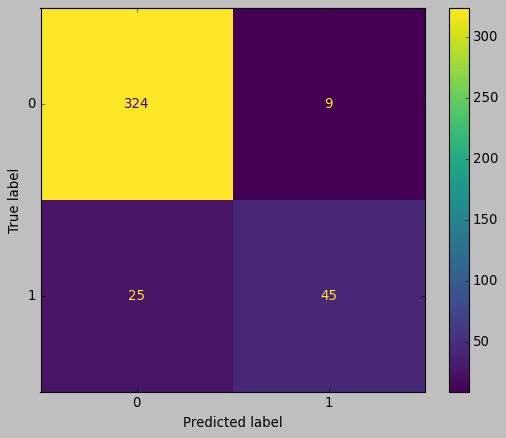

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix for predictions on test data
plt.style.use('classic')
test_pred = model_rfc.best_estimator_.predict(features_test[selected_features])
confusion_matrix(target_test, test_pred)

ConfusionMatrixDisplay.from_estimator(model_rfc, features_test[selected_features], target_test);

In [15]:
# extract most important features
#pd.options.display.float_format= "{:.8f}".format
#model_rfc.best_estimator_.steps[1][1].feature_importances_
#feature_importances = pd.DataFrame(model_rfc.best_estimator_.steps[1][1].feature_importances_, index=model_rfc.best_estimator_.steps[0][1].get_feature_names_out()).sort_values(by=0, ascending=True)
#least_important_features = feature_importances.head(10).index
#most_important_features = feature_importances.tail(12).index
#display(least_important_features)
#display(most_important_features)

#test_pred = model_rfc.best_estimator_.predict(features_test[most_important_features])
#confusion_matrix(target_test, test_pred)

In [16]:

# Best score with all features
# Pipeline(steps=[('transformer',
#                  ColumnTransformer(remainder='passthrough', transformers=[])),
#                 ('model',
#                  RandomForestClassifier(class_weight='balanced', max_depth=25,
#                                         min_samples_leaf=3, n_estimators=209,
#                                         n_jobs=-1, random_state=42))])
# recall: 0.6571428571428571
# precision: 0.7796610169491526
# f1: 0.7131782945736433
# accuracy: 0.9081885856079405

# Best score with only top 5 features extracted from feature_importance of DecisionTreeClassifier
# ['Age', 'Tumor Size', 'Survival Months', 'Regional Node Examined', 'Regional Node Positive']

# Pipeline(steps=[('preprocessing',
#                  ColumnTransformer(remainder='passthrough', transformers=[])),
#                 ('model',
#                  RandomForestClassifier(class_weight='balanced', max_depth=1,
#                                         n_estimators=25, n_jobs=-1,
#                                         random_state=42))])
# recall: 0.6571428571428571
# precision: 0.8214285714285714
# f1: 0.73015873015873
# accuracy: 0.9156327543424317


In [17]:
# RandomForestClassifier
pipeline_rf = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                        ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                        ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=42))])

pipeline_rf.fit(features_train, target_train)

target_test_pred_rf = pipeline_rf.predict(features_test)

scores = {'name': "RandomForestClassifier",
          'accuracy': accuracy_score(target_test,target_test_pred_rf) * 100,
          'precision': precision_score(target_test,target_test_pred_rf) * 100,
          'recall': recall_score(target_test,target_test_pred_rf) * 100,
          'f1': f1_score(target_test,target_test_pred_rf) * 100,
         }
model_results.append(scores)
pd.DataFrame(model_results).T

,0,1,2
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier
accuracy,92.059553,91.563275,90.322581
precision,85.185185,83.333333,87.804878
recall,65.714286,64.285714,51.428571
f1,74.193548,72.580645,64.864865


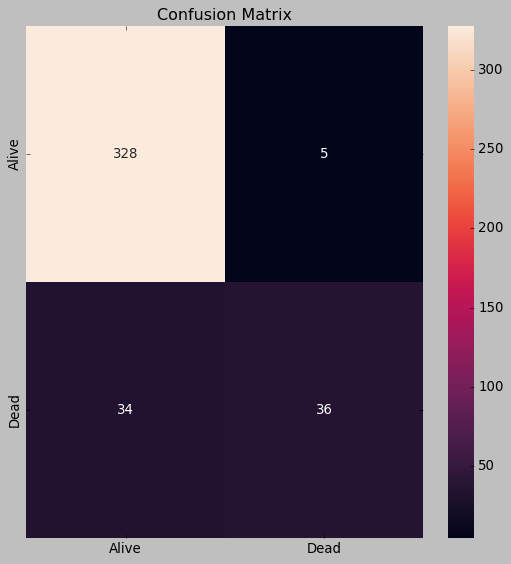

In [18]:
# confusion matrix for RandomForestClassifier
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_test_pred_rf)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [19]:
# report
report = classification_report(target_test, target_test_pred_rf)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       333
           1       0.88      0.51      0.65        70

    accuracy                           0.90       403
   macro avg       0.89      0.75      0.80       403
weighted avg       0.90      0.90      0.89       403



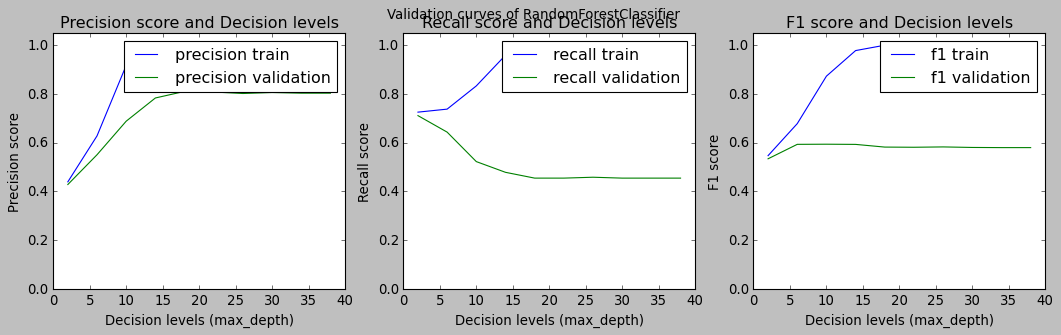

In [20]:
from sklearn.model_selection import validation_curve

# set-up for validation curve: which max_depth-settings to try
search_space = range(2, 40,4)

# initialize figures with two axes
fig, ax = plt.subplots(ncols=3, figsize=[16, 4])
fig.suptitle('Validation curves of RandomForestClassifier')

# precision

# calculate precision values of different hyperparameter settings and cross validation folds
precision_train, precision_val = validation_curve(estimator=pipeline_rf.named_steps['classifier'], 
                                                  X=pipeline_rf.named_steps['preprocessing'].fit_transform(features_train, target_train), 
                                                  y=target_train, 
                                                  param_name='max_depth',
                                                  param_range=search_space,
                                                  cv=5,
                                                  scoring='precision')

# calculate average precision values for each hyperparameter setting
precision_train_mean = np.mean(precision_train, axis=1)
precision_val_mean = np.mean(precision_val, axis=1)

# plot validation curve
ax[0].plot(search_space,
           precision_train_mean, label='precision train')
ax[0].plot(search_space,
           precision_val_mean, label='precision validation')
ax[0].set(ylim=[0, 1.05],
          xlabel='Decision levels (max_depth)',
          ylabel='Precision score',
          title='Precision score and Decision levels')
ax[0].legend()

# recall

# calculate recall values of different hyperparameter settings and cross validation folds
recall_train, recall_val = validation_curve(estimator=pipeline_rf.named_steps['classifier'], 
                                            X=pipeline_rf.named_steps['preprocessing'].fit_transform(features_train, target_train), 
                                            y=target_train, 
                                            param_name='max_depth',
                                            param_range=search_space,
                                            cv=5,
                                            scoring='recall')

# calculate average recall values for each hyperparameter setting
recall_train_mean = np.mean(recall_train, axis=1)
recall_val_mean = np.mean(recall_val, axis=1)

# plot validation curve
ax[1].plot(search_space,
           recall_train_mean, label='recall train')
ax[1].plot(search_space,
           recall_val_mean, label='recall validation')
ax[1].set(ylim=[0, 1.05],
          xlabel='Decision levels (max_depth)',
          ylabel='Recall score',
          title='Recall score and Decision levels')
ax[1].legend()

# f1 score

# calculate precision values of different hyperparameter settings and cross validation folds
precision_train, precision_val = validation_curve(estimator=pipeline_rf.named_steps['classifier'], 
                                                  X=pipeline_rf.named_steps['preprocessing'].fit_transform(features_train, target_train), 
                                                  y=target_train, 
                                                  param_name='max_depth',
                                                  param_range=search_space,
                                                  cv=5,
                                                  scoring='f1')

# calculate average precision values for each hyperparameter setting
precision_train_mean = np.mean(precision_train, axis=1)
precision_val_mean = np.mean(precision_val, axis=1)

# plot validation curve
ax[2].plot(search_space,
           precision_train_mean, label='f1 train')
ax[2].plot(search_space,
           precision_val_mean, label='f1 validation')
ax[2].set(ylim=[0, 1.05],
          xlabel='Decision levels (max_depth)',
          ylabel='F1 score',
          title='F1 score and Decision levels')
ax[2].legend()

In [21]:
# Run GridSearch with RandomForest


# Create the parameter grid
grid_search_rf = [{'classifier__max_depth':range(2, 40,4),#[10,11,12,13,14,15, 20],       
                    'classifier__max_features':[2, 3, 4, 5, 6, 8, 20,"auto"],
                    'classifier__min_samples_split':[2, 3, 4],
                    'classifier__min_samples_leaf':[2, 3, 4]
                  }]

# Create an instance of GridSearch 
grid_rf = GridSearchCV(estimator=pipeline_rf,
                     param_grid = grid_search_rf,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

# Train the RandomForestClassifier
grid_rf.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_rf.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_rf.best_params_)

# Print the val score of the best model
#predict
target_test_pred_rf_grid = grid_rf.best_estimator_.predict(features_test)

#save
scores = {'name': "RandomForest optimized",
          'accuracy': accuracy_score(target_test, target_test_pred_rf_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_rf_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_rf_grid) * 100,
          'f1': f1_score(target_test, target_test_pred_rf_grid) * 100,
        }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

best score
0.6237092073706786
best model parameter
{'classifier__max_depth': 14, 'classifier__max_features': 6, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2}


,0,1,2,3
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized
accuracy,92.059553,91.563275,90.322581,90.818859
precision,85.185185,83.333333,87.804878,77.966102
recall,65.714286,64.285714,51.428571,65.714286
f1,74.193548,72.580645,64.864865,71.317829


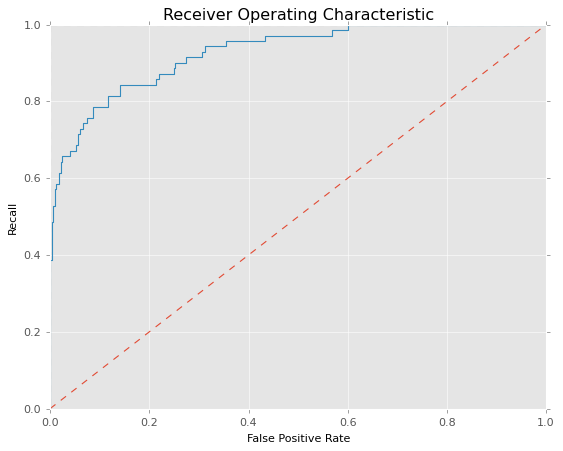

In [22]:
# print roc-curve

# create DataFrame with one column named prediction
df_pred_test = pd.DataFrame(target_test_pred_rf_grid, columns=['prediction'])

# predict probabilities and add them as new column
df_pred_test.loc[:, 'probability'] = grid_rf.best_estimator_.predict_proba(features_test)[:, 1]  

# calculate roc-curve
from sklearn.metrics import roc_curve

false_positive_rate, recall, threshold = roc_curve(target_test, df_pred_test.loc[:, 'probability']) 

# plotting
plt.style.use('ggplot')

# figure and axes intialisation
fig, ax = plt.subplots()

# reference lines
ax.plot([0, 1], ls = "--")  # blue diagonal
ax.plot([0, 0], [1, 0], c=".7", ls='--')  # grey vertical
ax.plot([1, 1], c=".7", ls='--')  # grey horizontal

# roc curve
ax.plot(false_positive_rate, recall)

# labels
ax.set_title("Receiver Operating Characteristic")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("Recall");

In [23]:
# Logistic Regression

# create Pipeline
pipeline_log = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols),
                     ()
                     ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))])

# fit pipeline on cleaned training set
pipeline_log.fit(features_train, target_train)

# predict and evaluate on test set

#predict
target_test_pred_log = pipeline_log.predict(features_test)

#save
scores = {'name': "LogisticRegression",
          'accuracy': accuracy_score(target_test, target_test_pred_log) * 100,
          'precision': precision_score(target_test, target_test_pred_log) * 100,
          'recall': recall_score(target_test, target_test_pred_log) * 100,
          'f1': f1_score(target_test, target_test_pred_log) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

ValueError: not enough values to unpack (expected 3, got 0)

In [ ]:
# report
report = classification_report(target_test, target_test_pred_log)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       333
           1       0.50      0.79      0.61        70

    accuracy                           0.82       403
   macro avg       0.72      0.81      0.75       403
weighted avg       0.87      0.82      0.84       403



In [ ]:
# Run GridSearch with LogisticRegression

# creat C_values
import numpy as np 
C_values = [0.01, 0.1, 1, 10, 100]

# creat parameter Grid
grid_search_log = [{'classifier__penalty':["l2","None"],
                    'classifier__solver': ['liblinear', 'lbfgs'],
                    'classifier__C': C_values
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_log = GridSearchCV(estimator=pipeline_log,
                     param_grid = grid_search_log,
                     scoring='f1',
                     cv=3,   
                     n_jobs=-1)

# Train the RandomForestClassifier
grid_log.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_log.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_log.best_params_)

# Print the test score of the best model
#predict
target_test_pred_log_grid = grid_log.best_estimator_.predict(features_test)

#save
scores = {'name': "LogisticRegression_GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_log_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_log_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_log_grid) * 100,
          'f1': f1_score(target_test, target_test_pred_log_grid) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T 

best score
0.5238762727030883
best model parameter
{'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


c:\Users\flori\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\flori\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\flori\anaconda3\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "c:\Users\flori\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "c:\Users\flori\an

,0,1,2,3,4,5
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized,LogisticRegression,LogisticRegression_GridSearch
accuracy,92.059553,91.563275,90.322581,90.818859,82.382134,82.382134
precision,85.185185,83.333333,87.804878,77.966102,49.54955,49.54955
recall,65.714286,64.285714,51.428571,65.714286,78.571429,78.571429
f1,74.193548,72.580645,64.864865,71.317829,60.773481,60.773481


In [ ]:
#Support Vector Machine with Gaussian kernel
from sklearn.svm import SVC 

# create Pipeline
pipeline_svc = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(C=1000, kernel="rbf", gamma='scale', class_weight='balanced', random_state=42))])

#fit Model
pipeline_svc.fit(features_train, target_train)

#predict
target_test_pred_rfb = pipeline_svc.predict(features_test)

#save
scores = {'name': "SVC with Gaussian kernel",
          'accuracy': accuracy_score(target_test, target_test_pred_rfb) * 100,
          'precision': precision_score(target_test, target_test_pred_rfb) * 100,
          'recall': recall_score(target_test, target_test_pred_rfb) * 100,
          'f1': f1_score(target_test, target_test_pred_rfb) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

,0,1,2,3,4,5,6
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized,LogisticRegression,LogisticRegression_GridSearch,SVC with Gaussian kernel
accuracy,92.059553,91.563275,90.322581,90.818859,82.382134,82.382134,80.148883
precision,85.185185,83.333333,87.804878,77.966102,49.54955,49.54955,43.902439
recall,65.714286,64.285714,51.428571,65.714286,78.571429,78.571429,51.428571
f1,74.193548,72.580645,64.864865,71.317829,60.773481,60.773481,47.368421


In [ ]:
# report
report = classification_report(target_test, target_test_pred_rfb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88       333
           1       0.44      0.51      0.47        70

    accuracy                           0.80       403
   macro avg       0.67      0.69      0.68       403
weighted avg       0.82      0.80      0.81       403



In [ ]:
# grid search with Support Vector Machine with Gaussian kernel

# create k values
k = np.geomspace(1,1000,10, dtype="int")
k = np.unique(k)

# Create the parameter grid
grid_search_svc = [{'classifier__C':[0.1,1, 10, 100],
                   'classifier__gamma':[1,0.1,0.01,0.001]
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_svc = GridSearchCV(estimator=pipeline_svc,
                     param_grid = grid_search_svc,
                     scoring='f1',
                     cv=3,
                     verbose =1,
                     n_jobs=-1)

# fit the Model
grid_svc.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_svc.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_svc.best_params_)

# Print the test score of the best model
#predict
target_test_pred_svc_grid = grid_svc.predict(features_test)

#save
scores = {'name': "SVC with Gaussian kernel and GridSearch",
          'accuracy': accuracy_score(target_test, target_test_pred_svc_grid) * 100,
          'precision': precision_score(target_test, target_test_pred_svc_grid) * 100,
          'recall': recall_score(target_test, target_test_pred_svc_grid) * 100,
          'f1': f1_score(target_test, target_test_pred_svc_grid) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best score
0.5367396728050355
best model parameter
{'classifier__C': 10, 'classifier__gamma': 0.01}


,0,1,2,3,4,5,6,7
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized,LogisticRegression,LogisticRegression_GridSearch,SVC with Gaussian kernel,SVC with Gaussian kernel and GridSearch
accuracy,92.059553,91.563275,90.322581,90.818859,82.382134,82.382134,80.148883,82.382134
precision,85.185185,83.333333,87.804878,77.966102,49.54955,49.54955,43.902439,49.50495
recall,65.714286,64.285714,51.428571,65.714286,78.571429,78.571429,51.428571,71.428571
f1,74.193548,72.580645,64.864865,71.317829,60.773481,60.773481,47.368421,58.479532


In [ ]:
# report
report = classification_report(target_test, target_test_pred_svc_grid)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       333
           1       0.50      0.71      0.58        70

    accuracy                           0.82       403
   macro avg       0.71      0.78      0.74       403
weighted avg       0.86      0.82      0.84       403



In [ ]:
#Support Vector Machine with polynomial kernel
from sklearn.svm import SVC 

# create Pipeline
pipeline_svc_poly = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)                   
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(C=1000, kernel='poly', degree=2, gamma='scale', class_weight='balanced', random_state=42))])

#fit Model
pipeline_svc_poly.fit(features_train,target_train)

#predict
target_test_pred_poly = pipeline_svc_poly.predict(features_test)

#save
scores = {'name': "SVC with polynomial kernel of degree 2",
          'accuracy': accuracy_score(target_test, target_test_pred_poly) * 100,
          'precision': precision_score(target_test, target_test_pred_poly) * 100,
          'recall': recall_score(target_test, target_test_pred_poly) * 100,
          'f1': f1_score(target_test, target_test_pred_poly) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

c:\Users\flori\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4,5,6,7,8
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized,LogisticRegression,LogisticRegression_GridSearch,SVC with Gaussian kernel,SVC with Gaussian kernel and GridSearch,SVC with polynomial kernel of degree 2
accuracy,92.059553,91.563275,90.322581,90.818859,82.382134,82.382134,80.148883,82.382134,83.126551
precision,85.185185,83.333333,87.804878,77.966102,49.54955,49.54955,43.902439,49.50495,51.219512
recall,65.714286,64.285714,51.428571,65.714286,78.571429,78.571429,51.428571,71.428571,60.0
f1,74.193548,72.580645,64.864865,71.317829,60.773481,60.773481,47.368421,58.479532,55.263158


In [ ]:
# report
report = classification_report(target_test, target_test_pred_poly)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90       333
           1       0.51      0.60      0.55        70

    accuracy                           0.83       403
   macro avg       0.71      0.74      0.72       403
weighted avg       0.84      0.83      0.84       403



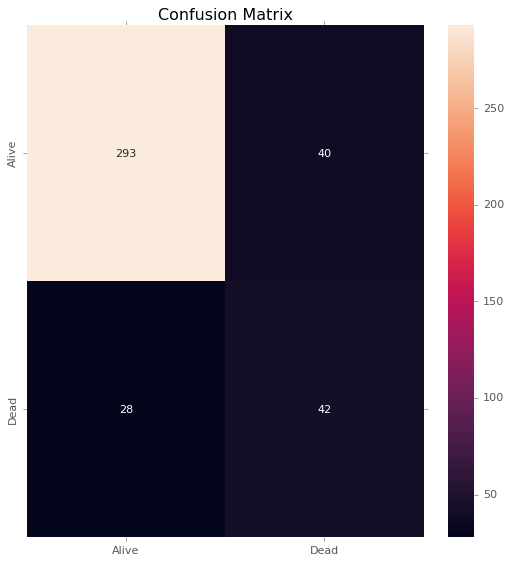

In [ ]:
labels = ['Alive', 'Dead']
cm = confusion_matrix(target_test, target_test_pred_poly)
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# grid search with linear Support Vector Machine

# make Pipeline
pipeline_svc_lin = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                     ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ('classifier', SVC(class_weight='balanced', random_state=42))])

# create k values
k = np.geomspace(1,1000,10, dtype="int")
k = np.unique(k)

# Create the parameter grid
grid_search_svc_lin = [{'classifier__C':[0.1,1, 10, 100],
                     'classifier__gamma':[1,0.1,0.01,0.001]
                    }]

# Create an instance of GridSearch Cross-validation estimator
grid_svc_lin = GridSearchCV(estimator=pipeline_svc_lin,
                     param_grid = grid_search_svc_lin,
                     scoring='f1',
                     cv=3,
                     verbose =1,
                     n_jobs=-1)

# fit the Model
grid_svc_lin.fit(features_train, target_train)

# Print the training score of the best model
print("best score")
print(grid_svc_lin.best_score_)

# Print the model parameters of the best model
print("best model parameter")
print(grid_svc_lin.best_params_)

# Print the test score of the best model
#predict
target_test_pred_svc_grid_lin = grid_svc_lin.predict(features_test)

#save
scores = {'name': "SVC_GridSearch with linear kernel",
          'accuracy': accuracy_score(target_test, target_test_pred_svc_grid_lin) * 100,
          'precision': precision_score(target_test, target_test_pred_svc_grid_lin) * 100,
          'recall': recall_score(target_test, target_test_pred_svc_grid_lin) * 100,
          'f1': f1_score(target_test, target_test_pred_svc_grid_lin) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best score
0.5367396728050355
best model parameter
{'classifier__C': 10, 'classifier__gamma': 0.01}


,0,1,2,3,4,5,6,7,8,9
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized,LogisticRegression,LogisticRegression_GridSearch,SVC with Gaussian kernel,SVC with Gaussian kernel and GridSearch,SVC with polynomial kernel of degree 2,SVC_GridSearch with linear kernel
accuracy,92.059553,91.563275,90.322581,90.818859,82.382134,82.382134,80.148883,82.382134,83.126551,82.382134
precision,85.185185,83.333333,87.804878,77.966102,49.54955,49.54955,43.902439,49.50495,51.219512,49.50495
recall,65.714286,64.285714,51.428571,65.714286,78.571429,78.571429,51.428571,71.428571,60.0,71.428571
f1,74.193548,72.580645,64.864865,71.317829,60.773481,60.773481,47.368421,58.479532,55.263158,58.479532


In [ ]:
# RandomForestClassifier with PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

#initate PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2,           
                                      interaction_only=False, # Controls whether self interactons are included 
                                      include_bias=False)    # Controls whether the 1 is also icluded as a feature

#initate model
model_forest = RandomForestClassifier(class_weight="balanced", random_state=0)

#create Pipeline
pipeline_rf_poly = Pipeline([('preprocessing', ColumnTransformer(transformers=[
                    ('encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                     ('ord_transformer', OrdinalEncoder(), ord_cols)
                    ], remainder='passthrough')),
                    ('scaler', StandardScaler()),
                    ("poly", poly_transformer),
                    ('classifier', RandomForestClassifier(class_weight="balanced", random_state=42))])

# Train the RandomForestClassifier
pipeline_rf_poly.fit(features_train, target_train)


#predict
target_test_pred_rf_poly = pipeline_rf_poly.predict(features_test)

#save
scores = {'name': "RandomForest_GridSearch_poly",
          'accuracy': accuracy_score(target_test,target_test_pred_rf_poly) * 100,
          'precision': precision_score(target_test,target_test_pred_rf_poly) * 100,
          'recall': recall_score(target_test,target_test_pred_rf_poly) * 100,
          'f1': f1_score(target_test,target_test_pred_rf_poly) * 100,
         }
model_results.append(scores)
    
#show results
pd.DataFrame(model_results).T

,0,1,2,3,4,5,6,7,8,9,10
name,DecisionTreeClassifier optimized,RandomForestClassifier with all features selected,RandomForestClassifier,RandomForest optimized,LogisticRegression,LogisticRegression_GridSearch,SVC with Gaussian kernel,SVC with Gaussian kernel and GridSearch,SVC with polynomial kernel of degree 2,SVC_GridSearch with linear kernel,RandomForest_GridSearch_poly
accuracy,92.059553,91.563275,90.322581,90.818859,82.382134,82.382134,80.148883,82.382134,83.126551,82.382134,92.059553
precision,85.185185,83.333333,87.804878,77.966102,49.54955,49.54955,43.902439,49.50495,51.219512,49.50495,95.238095
recall,65.714286,64.285714,51.428571,65.714286,78.571429,78.571429,51.428571,71.428571,60.0,71.428571,57.142857
f1,74.193548,72.580645,64.864865,71.317829,60.773481,60.773481,47.368421,58.479532,55.263158,58.479532,71.428571


In [ ]:
# report
report = classification_report(target_test, target_test_pred_rf_poly)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       333
           1       0.95      0.57      0.71        70

    accuracy                           0.92       403
   macro avg       0.93      0.78      0.83       403
weighted avg       0.92      0.92      0.91       403

